# Read data and create timeseries using PICES LME

Look at SST, ocean currents, chl-a

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def weighted_mean_of_masked_data(data_in,data_mask,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean

def weighted_mean_of_data(data_in,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    #pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat'),keep_attrs=True) / total_ocean_area
    return data_weighted_mean


adir_data = './data/'

# Read in PICES mask

- Each dataset finds a unique and different way to define lat / lon or order them.
- There is a need for standardization in this area
- The basic PICES mask is -180 to 180 lon and -90 to 90 lat
- Below different maps are created for 0 to 360 lon
- Then each of the two different lon maps are also copied to reverse lat, 90 to -90

In [2]:
#read in mask file
filename = './data/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
#read in mask file
filename = './data/PICES_all_mask360.nc'
ds_pices360 = xr.open_dataset(filename)
ds_pices360.close()

ds_pices_revlat = ds_pices.sortby(ds_pices.lat, ascending = False)
ds_pices360_revlat = ds_pices360.sortby(ds_pices360.lat, ascending = False)



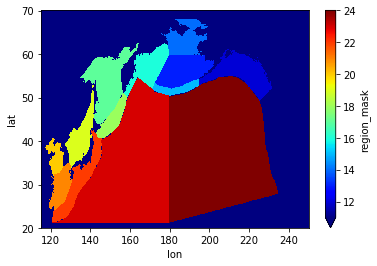

In [5]:
ds_pices360.sel(lon=slice(115,250),lat=slice(20,70)).region_mask.plot(vmin=11,vmax=24,cmap='jet')

(array([ 21130.,  17355.,  15366.,  11188.,   4023.,  11715.,  21365.,
          6144.,  10643.,   4422.,   7316.,  12566., 108525., 140022.,
             0.,      0.]),
 array([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5]),
 <a list of 16 Patch objects>)

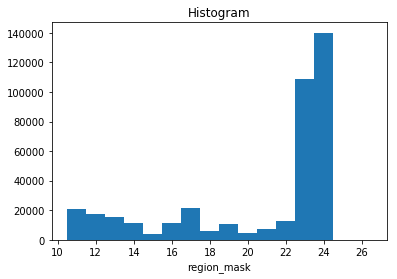

In [6]:
ds_pices.region_mask.plot.hist(bins=np.arange(10.5,27))

## Read in SST data

In [7]:
ds = xr.open_dataset('./data/sst.mnmean.nc')
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#interpolate mask
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')

#create sst mean for pices region
for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds.sst,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        sst_mean=tem
    else:
        sst_mean = xr.concat([sst_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
sst_climatology = sst_mean.groupby('time.month').mean('time')
sst_anomalies = sst_mean.groupby('time.month') - sst_climatology

sst_mean.to_netcdf(adir_data+'sst_mean.nc')
sst_climatology.to_netcdf(adir_data+'sst_climatology.nc')
sst_anomalies.to_netcdf(adir_data+'sst_anomalies.nc')

lat range 89.5 -89.5
lon range 0.5 359.5


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


## Read in wind data

In [8]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdlasFnWind10'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'}).drop({'taux_mean','tauy_mean','curl'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#interpolate mask
mask_interp = ds_pices360.interp_like(ds,method='nearest')

for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        wnd_mean=tem
    else:
        wnd_mean = xr.concat([wnd_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
wnd_climatology = wnd_mean.groupby('time.month').mean('time')
wnd_anomalies = wnd_mean.groupby('time.month') - wnd_climatology

wnd_mean.to_netcdf(adir_data+'wnd_mean.nc')
wnd_climatology.to_netcdf(adir_data+'wnd_climatology.nc')
wnd_anomalies.to_netcdf(adir_data+'wnd_anomalies.nc')

lat range -90.0 90.0
lon range 0.0 359.0


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

## Read in Ocean current data

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar'
ds = xr.open_dataset(aggr_url).isel(depth=0).rename({'latitude':'lat','longitude':'lon'}).drop({'um','vm'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#subset
ds = ds.sel(lon=slice(115,250),lat=slice(70,20))

#interpolate mask
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')

for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        cur_mean=tem
    else:
        cur_mean = xr.concat([cur_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
cur_climatology = cur_mean.groupby('time.month').mean('time')
cur_anomalies = cur_mean.groupby('time.month') - cur_climatology


## Read in chl-a data

In [ ]:

wnd_mean

## Testing still

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorMonthly'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

m=[]
for imon in range(0,250,5):
    ds2 = ds.isel(time=slice(imon,imon+5)).sel(lat=slice(70,20))
    ds3 = ds2.interp(lat=np.arange(70,20),lon=np.arange(-180,180))
    if imon==0:
        m=ds3
    else:
        m.append(ds3)
ds = m    

In [ ]:
#create  mean for pices region
iregion=13
mask_interp = ds_pices_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
chl_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
chl_climatology = chl_mean.groupby('time.month').mean('time')
chl_anomalies = chl_mean.groupby('time.month') - chl_climatology


In [ ]:
                ds_mean['spd']=(ds_mean.uwnd**2+ds_mean.vwnd**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.vwnd,ds_mean.uwnd)* 180./pi                
